In [411]:
import pysam
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd
import numpy as np

In [442]:

NM_PERCENTAGE_THRESHOLD = 0.1 # Contigs will be hidden and excluded from statistics if NM_percentage >= NM_PERCENTAGE_THRESHOLD; parameter used to exclude mismapped contigs
INSERTION_THRESHOLD = 10 # Insertions will hidden if length < INSERTION_THRESHOLD
INSERTION_THRESHOLD_2 = 100 # Insertions will be highlighted if length >= INSERTION_THRESHOLD_2
DELETION_THRESHOLD = 1 # Delections will not be displayed if length < DELETION_THRESHOLD
ALIGN_CONTINGENCY = 10 # Blocks will not be displayed if length < ALIGN_CONTINGENCY

GENE_LABEL_THRESHOLD = 5000 # Only genes longer than GENE_LABEL_THRESHOLD will be labelled

RECTANGLE_HEIGHT = 0.2
INTER_ASSEMBLY_PADDING = 1
X_PADDING = 0.03

In [478]:
class Canvas:
    def __init__(self):
        self.assemblies = []
        self.annotations = []
        self.y = 0
        self.left_limit = None
        self.right_limit = None
        
    def add_assembly(self, assembly):
        assembly.y0 = self.y
        self.assemblies.append(assembly)
        self.y += len(assembly.rows) + INTER_ASSEMBLY_PADDING
        
    def add_annotation(self, annotation):
        annotation.y = self.y
        self.y += 2
        self.annotations.append(annotation)
        
    def load_genes(self):
        gene_file = "genes.tsv"
        gene_data = pd.read_table(gene_file)
        gene_data["tx_length"] = gene_data['txEnd'] - gene_data['txStart']
        gene_data.sort_values(by = ['tx_length'], ascending = False)
        gene_data = gene_data.drop_duplicates(subset = ['name2'])
        genes = []
        for index, row in gene_data.iterrows():
            gene = Gene(name = row["name2"], region = 
                        Region(None, chromosome = row['chrom'], left = row['txStart'], right = row['txEnd']))
            if row["cdsStart"] == row["cdsEnd"]:
                gene.protein_coding = False
            else:
                gene.protein_coding = True

            if region_overlap(gene.region, self.target_region):
                genes.append(gene)
                
        gene_annotation = Annotation("Genes")
        for gene in genes:
            gene_annotation.add_entry(gene)
            
        self.add_annotation(gene_annotation)
        
        
    def draw(self): 
        # Determine x and y limits
        x_min = None
        x_max = None
        
        for assembly in self.assemblies:
            if x_min is None or x_min > assembly.left:
                x_min = assembly.left
            if x_max is None or x_max < assembly.right:
                x_max = assembly.right

        if self.left_limit and self.right_limit:
            x_min = self.left_limit
            x_max = self.right_limit
        
        # Create figure
        plt.figure(figsize = (10, 0.5 * self.y))
        
        # Plot assemblies
        for assembly in self.assemblies:
            assembly.draw()
            
        # Load genes
        self.load_genes()
        
        # Plot genes
        for annotation in self.annotations:
            annotation.draw()
        
        # Set x and y limits
        delta_x = X_PADDING * (x_max - x_min)
        plt.xlim(x_min - delta_x, x_max + delta_x)
        
        plt.ylim(0, self.y)
        
        # Label assemblies and annotations
        for assembly in self.assemblies:
            plt.text(x_max, assembly.y0 + 0.05, assembly.name, ha = 'right', va = 'bottom')
            
        for annotation in self.annotations:
            plt.text(x_max, annotation.y + 0.05, annotation.name, ha = 'right', va = 'bottom')
            
        # Draw a pair of vertical lines marking our region of interest
        plt.gca().axvline(x = self.target_region.left, linewidth=1, linestyle='--', color='whitesmoke', zorder = 0.1)
        plt.gca().axvline(x = self.target_region.right, linewidth=1, linestyle='--', color='whitesmoke', zorder = 0.1)
        
        # Hide ticks on y axis
        plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
        # Misc
        plt.xlabel("Reference postition")
        plt.tight_layout()
        
    def limit_region(self, target_region):
        # Remove contigs outside the target region
        self.target_region = Region(region_str = target_region)
        self.chromosome, self.left_limit, self.right_limit = parse_region(target_region)
        
        for assembly in self.assemblies:
            for row in assembly.rows:
                row.contigs = [contig for contig in row.contigs if contig.right >= self.left_limit 
                               and contig.left <= self.right_limit 
                               and contig.reference_name == self.chromosome]
            
            assembly.compute_statistics(target_region)
                
        
    def __repr__(self):
        output = "Target region: {region}\n\n".format(region = self.target_region)
        for annotation in self.annotations:
            output += annotation.__repr__()
        for assembly in self.assemblies:
            output += assembly.__repr__()
        return output
    

class Assembly:
    def __init__(self, y0 = 0, name = ""):
        self.rows = []
        self.name = name
        self.y0 = y0
        self.y = y0
        self.left = None
        self.right = None
        
    def add_contig(self, contig):
        if contig.NM_percentage >= NM_PERCENTAGE_THRESHOLD:
            return
        
        if self.left is None or self.left > contig.left:
            self.left = contig.left
        if self.right is None or self.right < contig.right:
            self.right = contig.right
            
        # Try to insert contig into one of the existing rows
        for row in self.rows:
            if row.check_overlap(contig) == False:
                row.add_contig(contig)
                return
        
        # Otherwise, create a new row and add the contig
        new_row = self.add_row()
        new_row.add_contig(contig)
        
        self.compute_statistics()
    
    def compute_statistics(self, target_region = None):
        self.contigs = []
        for row in self.rows:
            self.contigs += row.contigs
        
        # NM
        self.NM = sum([contig.NM for contig in self.contigs])
        self.total_contig_width = sum([contig.width for contig in self.contigs])
        self.NM_percentage = self.NM / self.total_contig_width
        
        
        # Contig, insertion and deletion lengths
        self.contig_lengths = [contig.width for contig in self.contigs]
        self.insertion_lengths = []
        self.deletion_lengths = []
        for contig in self.contigs:
            for insertion in contig.insertions:
                self.insertion_lengths.append(insertion.length)
            for deletion in contig.deletions:
                self.deletion_lengths.append(deletion.width)
        
        
        if not target_region:
            return
        
        chromosome, ref_left, ref_right = parse_region(target_region)
        ref_size = ref_right - ref_left + 1
        
        # NG50
        self.contigs.sort(key = lambda contig: contig.width, reverse = True)
        
        total_width = 0
        self.NG50 = 0
        for contig in self.contigs:
            total_width += contig.width
            if total_width >= 0.5 * ref_size:
                self.NG50 = contig.width
                break
                
        # Ref_coverage
        ref_covered = [False for position in range(ref_right - ref_left + 1)]
        for contig in self.contigs:
            contig_start = contig.left - ref_left
            contig_end = contig.right - ref_left
            if contig_start < 0:
                contig_start = 0
            if contig_end > ref_right - ref_left:
                contig_end = ref_right - ref_left
            for i in range(contig_start, contig_end + 1):
                ref_covered[i] = True
        self.ref_coverage = sum(ref_covered) / ref_size
        
        # Coverage
        ref_covered = [False for position in range(ref_right - ref_left + 1)]
        coverage = pd.DataFrame(columns = ("i", "contig_length", "covered_percentage"))
        i = 0
        for contig in self.contigs:
            i += 1
            contig_start = contig.left - ref_left
            contig_end = contig.right - ref_left
            if contig_start < 0:
                contig_start = 0
            if contig_end > ref_right - ref_left:
                contig_end = ref_right - ref_left
            for j in range(contig_start, contig_end + 1):
                ref_covered[j] = True
            covered_percentage = sum(ref_covered) / ref_size
            coverage = coverage.append(
                pd.DataFrame({"i":[i], "contig_length":[contig.width], "covered_percentage":[covered_percentage]}))
        
        self.coverage = coverage
        
        # NG50 & NG90
        self.NG50 = None
        self.NG90 = None
        for index, row in self.coverage.iterrows():
            if row.covered_percentage >= 0.5 and self.NG50 is None:
                self.NG50 = row.contig_length
            if row.covered_percentage >= 0.9 and self.NG90 is None:
                self.NG90 = row.contig_length

                
        # Max ref coverage
        self.max_coverage = self.coverage.iloc[-1, 2]
        
    def add_row(self):
        self.y += 1
        new_row = Row(self.y)
        self.rows.append(new_row)
        return new_row

    def draw(self):
        for row in self.rows:
            row.draw(self.y0)
            
        # Draw a horizontal seperating line
        plt.gca().axhline(y = self.y0, linewidth=1, color='whitesmoke')
        
    def NGx_plot(self):
        x = [0]
        y = [self.coverage.iloc[0, 1]]
        for i in range(len(self.coverage) - 1):
            x.append(self.coverage.iloc[i, 2])
            y.append(self.coverage.iloc[i, 1])

            x.append(self.coverage.iloc[i + 1, 2])
            y.append(self.coverage.iloc[i, 1])

        x.append(self.coverage.iloc[-1, 2])
        y.append(self.coverage.iloc[-1, 1])
        
        plt.plot(x, y, label = self.name)
        plt.xlabel("x")
        plt.ylabel("NGx")
        plt.legend(frameon=False)
        
        # Set x ticks to percentage format
        ax = plt.gca()
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        

    def __repr__(self):
        output = "Assembly {name} (y0 = {y0}; NM% = {NM_percentage}; NG50 = {NG50}; Max_coverage% = {max_coverage})\n".format(
            name=self.name, y0=self.y0, NM_percentage = round(self.NM_percentage * 100, 2), 
            NG50 = self.NG50, max_coverage = round(self.max_coverage * 100, 2))
        for row in self.rows:
            output += row.__repr__()
        return output
        

class Row:
    def __init__(self, y):
        self.y = y
        self.contigs = []
        
    def check_overlap(self, contig, padding = 10):
        overlapped = False
        for existing_contig in self.contigs:
            if contig.left >= existing_contig.left - padding and contig.left <= existing_contig.right + padding or \
            contig.right >= existing_contig.left - padding and contig.right <= existing_contig.right + padding:
                overlapped = True
        return overlapped
    
    def add_contig(self, contig):
        self.contigs.append(contig)
        
    def draw(self, y0):
        for contig in self.contigs:
            contig.draw(self.y + y0)
            
    def __repr__(self):
        output = "\tRow {y}\n".format(y = self.y)
        for contig in self.contigs:
            output += contig.__repr__() + "\n"
        return output
            
            

class Contig:
    def __init__(self, contig_data):
        self.blocks = []
        self.left = None
        self.right = None
        self.width = None
        self.reference_name = contig_data.reference_name

        # Add blocks
        blocks_data = contig_data.get_blocks()
        for block_data in blocks_data:
            left, right = block_data[0], block_data[1]
            block = Block(left, right)
            self.add_block(block)
            
        # Add insertions and deletions
        aligned_pairs = contig_data.get_aligned_pairs()
        self.insertions = detect_insertions(aligned_pairs)
        self.deletions = detect_deletions(aligned_pairs)
        
        # Compute statictics
        self.NM = contig_data.get_tag('NM')
        self.NM_percentage = self.NM / self. width
        
        # self.NM_percentage = sum([block.width + 1 for block in self.blocks]) / (self.width + 1)
        
        
    def add_block(self, block):
        self.blocks.append(block)
        if self.left is None or self.left > block.left:
            self.left = block.left
        if self.right is None or self.right < block.left:
            self.right = block.right
        self.width = self.right - self.left
            
    def draw(self, y):
        
        # Draw a line across the contig
        width = self.right - self.left
        line_height = 0.05
        ax = plt.gca()
        global RECTANGLE_HEIGHT
        ax.add_patch(patches.Rectangle((self.left, y + 0.5 * RECTANGLE_HEIGHT - 0.5 * line_height), 
                                       width, line_height, facecolor = "darkgray", edgecolor=None, zorder=0.8))
        for block in self.blocks:
            block.draw(y)
        
        if self.insertions:
            for insertion in self.insertions:
                insertion.draw(y)
        
        if self.deletions:
            for deletion in self.deletions:
                deletion.draw(y)
        
            
    def __repr__(self):
        return "\t\tContig {left}-{right} (NM% = {NM}; {n_insertion} insertions; {n_deletion} deletions; {n} blocks) ".format(
            left = self.left, right = self.right, n = len(self.blocks),
            NM = round(self.NM_percentage * 100, 2), n_insertion = len(self.insertions), n_deletion = len(self.deletions))

class Block:
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.width = self.right - self.left + 1
        self.y = None
        
    def draw(self, y):
        if self.right - self.left < ALIGN_CONTINGENCY:
            return
        else:
            rectangle_color = "forestgreen"
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=1, facecolor=rectangle_color, edgecolor=None))
        
class Insertion:
    def __init__(self, position, length):
        self.position = position
        self.length = length
    def draw(self, y):
        global INSERTION_THRESHOLD
        if self.length < INSERTION_THRESHOLD:
            return
        if not self.position or not y:
            return
        if self.length >= INSERTION_THRESHOLD_2:
            marker_color = 'red'
        else:
            marker_color = 'purple'
        plt.plot(self.position, y, marker = align_marker("^", valign="top"), color=marker_color, markersize=6, markeredgewidth=0)
        
    def __repr__(self):
        return "Insertion(position = {position}, length = {length})".format(
            position = self.position, length = self.length)
    
class Deletion():
    def __init__(self, left, right):
        self.left = left
        self.right = right
        self.width = self.right - self.left + 1
    def __repr__(self):
        output = "Deletion(width = {width}) ".format(width = self.width)
        return output
    def draw(self, y):
        if self.width < DELETION_THRESHOLD:
            return
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=2, facecolor='red', edgecolor=None))

In [479]:
def detect_insertions(aligned_pairs):
    # How to distinguish between small deletions and poorly assemblied regions?
    length = 0
    position = 0
    insertions = []
    for query, reference in aligned_pairs:
        if query and not reference:
            if length == 0: # Start of a new insertion              
                pass
            else: # Continue current insertion
                pass
            length += 1
            
        else:
            if length == 0: # Matched pair; record position
                position = reference
            else: # End current insertion
                insertions.append(Insertion(position, length))
                position = 0
                length = 0
    return insertions

        

In [480]:
def detect_deletions(aligned_pairs):
    deletions = []
    left = None
    right = None
    for query, reference in aligned_pairs:
        if reference and not query: 
            if not left: # Start of a new deletion
                left = reference
                right = left + 1
            else: # Continue current deletion
                right = reference
        else:
            if not left: # Matched pair; record position
                pass
            else: # End current insertion
                deletions.append(Deletion(left, right))
                left = None
                right = None
    return deletions
        

In [481]:
def parse_region(region):
    # region format: chr14:105094527-106881340
    chromosome, interval = region.split(":")
    left_limit, right_limit = interval.split("-")
    left_limit = int(left_limit)
    right_limit = int(right_limit)
    return chromosome, left_limit, right_limit

In [482]:
from matplotlib import markers
from matplotlib.path import Path

def align_marker(marker, halign='center', valign='middle',):
    """
    create markers with specified alignment.
    From: https://stackoverflow.com/questions/26686722/align-matplotlib-scatter-marker-left-and-or-right

    Parameters
    ----------

    marker : a valid marker specification.
      See mpl.markers

    halign : string, float {'left', 'center', 'right'}
      Specifies the horizontal alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'center',
      -1 is 'right', 1 is 'left').

    valign : string, float {'top', 'middle', 'bottom'}
      Specifies the vertical alignment of the marker. *float* values
      specify the alignment in units of the markersize/2 (0 is 'middle',
      -1 is 'top', 1 is 'bottom').

    Returns
    -------

    marker_array : numpy.ndarray
      A Nx2 array that specifies the marker path relative to the
      plot target point at (0, 0).

    Notes
    -----
    The mark_array can be passed directly to ax.plot and ax.scatter, e.g.::

        ax.plot(1, 1, marker=align_marker('>', 'left'))

    """

    if isinstance(halign, (bytes, str)):
        halign = {'right': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'left': 1.,
                  }[halign]

    if isinstance(valign, (bytes, str)):
        valign = {'top': -1.,
                  'middle': 0.,
                  'center': 0.,
                  'bottom': 1.,
                  }[valign]

    # Define the base marker
    bm = markers.MarkerStyle(marker)

    # Get the marker path and apply the marker transform to get the
    # actual marker vertices (they should all be in a unit-square
    # centered at (0, 0))
    m_arr = bm.get_path().transformed(bm.get_transform()).vertices

    # Shift the marker vertices for the specified alignment.
    m_arr[:, 0] += halign / 2
    m_arr[:, 1] += valign / 2

    return Path(m_arr, bm.get_path().codes)

In [483]:
def read_bam_file(bam_file, assembly_name = None):
    if not assembly_name: 
        # Use bamfile name without extension as assembly name
        base_name = os.path.basename(bam_file)
        assembly_name = os.path.splitext(base_name)[0]
    assembly = Assembly(name = assembly_name)
    bam = pysam.AlignmentFile(bam_file, 'rb')
    
    contigs = []
    for contig_data in bam.fetch():
        contig = Contig(contig_data)    
        contigs.append(contig)
    
    # Sort contigs by width to ensure longer contigs are plotted before shorter contigs
    contigs.sort(key = lambda contig: contig.width, reverse=True)
    for contig in contigs:
        assembly.add_contig(contig)
    return assembly

In [484]:
class Region():
    def __init__(self, region_str = None, chromosome = None, left = None, right = None):
        if region_str:
            self.chromosome, self.left, self.right = parse_region(region_str)
        elif chromosome and left and right:
            self.chromosome, self.left, self.right = chromosome, left, right
        else:
            raise Exception("Incorrect parameters")
            
        self.width = self.right - self.left + 1
    
    def __repr__(self):
        output = "Region {chromosome}:{left}-{right}".format(chromosome = self.chromosome, left = self.left, right = self.right)
        return output

In [485]:
class Annotation():
    def __init__(self, name):
        self.name = name
        self.entries = []
        self.y = None
    
    def add_entry(self, entry):
        self.entries.append(entry)
    
    def draw(self):
        for entry in self.entries:
            entry.draw(self.y + 1)
            
        # Draw a horizontal seperating line
        plt.gca().axhline(y = self.y, linewidth=1, color='whitesmoke')
    
    def __repr__(self):
        output = "Annotation {name} (y = {y})\n".format(name = self.name, y = self.y)
        for entry in self.entries:
            output += entry.__repr__()
        return output

In [491]:
class Gene():
    def __init__(self, name, region):
        self.name = name
        self.chromosome, self.left, self.right = region.chromosome, region.left, region.right
        self.width = self.right - self.left + 1
        self.region = region
        self.exons = []
        self.protein_coding = None
    def draw(self, y):
        
        # Only draw protein-coding genes
        if not self.protein_coding:
            return
        
        c = np.random.rand(3,) * 0.8
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=1, 
                                       facecolor=c, edgecolor=None))
        
        center = (self.left + self.right)/2
        if self.width >= GENE_LABEL_THRESHOLD:
            plt.text(center, y - 0.1, self.name, ha='center', va='top', color=c, fontsize=3, rotation = 90)
        
    def add_exon(self, exon):
        assert exon.chromosome == self.chromosome and exon.left >= self.left and exon.right <= self.right
        self.exons.append(exon)
        
    def __repr__(self):
        output = "\tGene {name} {chromosome}:{left}-{right} ({n} exons)\n".format(
            name = self.name, chromosome = self.chromosome, left = self.left, right = self.right, n = len(self.exons))
        return output

In [492]:
class Exon():
    def __init__(self, region):
        self.chromosome, self.left, self.right = parse_region(region)
    def draw(self, y):
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((self.left, y), self.width, RECTANGLE_HEIGHT, zorder=1, 
                                       facecolor='gray', edgecolor='red'))

In [493]:
def region_overlap(region1, region2):
    if region1.chromosome != region2.chromosome:
        return False
    if region1.right >= region2.left and region1.right <= region2.right:
        return True
    if region1.left >= region2.left and region1.left <= region2.right:
        return True
    if region1.left <= region2.left and region1.right >= region2.right:
        return True
    return False

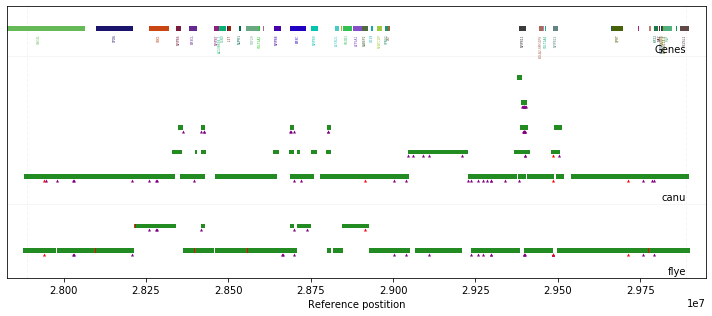

In [494]:
path = "data/IL27/"
filenames = ['flye.bam', 'canu.bam']

assemblies = [read_bam_file(path + filename) for filename in filenames]

canvas = Canvas()
for assembly in assemblies:
    canvas.add_assembly(assembly)

canvas.limit_region("chr16:27888679-29888679")
canvas.draw()

plt.savefig("3.svg")

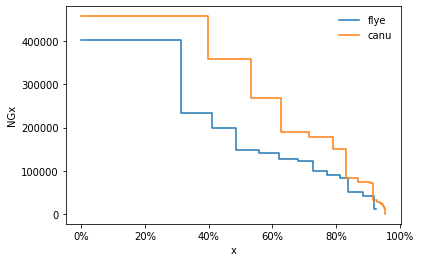

In [495]:
for assembly in canvas.assemblies:
    assembly.NGx_plot()